In [11]:
import os
import json
import numpy as np
import pandas as pd
from random import shuffle
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!unzip -qn /content/drive/MyDrive/crop_data_train_val.zip -d /content/data/

In [4]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 32.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [5]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [7]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

In [6]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [8]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')

In [20]:
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

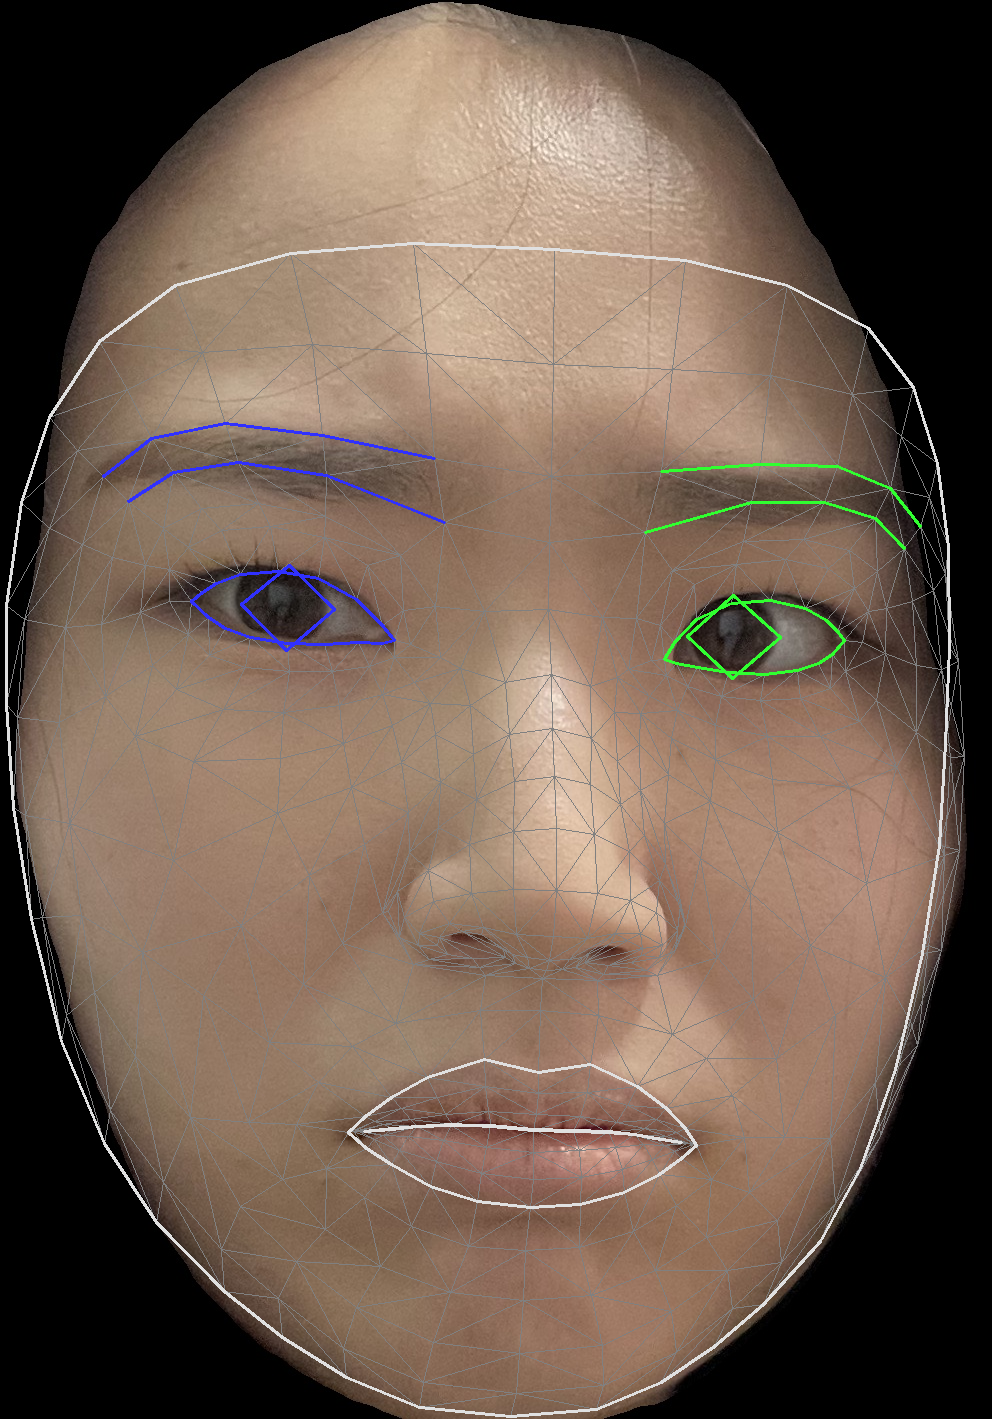

In [21]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file("/content/data/train/anger_crop/anger1.jpg")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [30]:
input_folder = "/content/data/train/anger_crop"
output_folder = "/content/anger_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [31]:
input_folder = "/content/data/train/happy_crop"
output_folder = "/content/happy_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [32]:
input_folder = "/content/data/train/panic_crop"
output_folder = "/content/panic_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [33]:
input_folder = "/content/data/train/sadness_crop"
output_folder = "/content/sadness_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [35]:
input_folder = "/content/data/val/anger_val_crop"
output_folder = "/content/val_anger_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [36]:
input_folder = "/content/data/val/happy_val_crop"
output_folder = "/content/val_happy_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [41]:
input_folder = "/content/data/val/panic_val_crop"
output_folder = "/content/val_panic_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [42]:
input_folder = "/content/data/val/sadness_val_crop"
output_folder = "/content/val_sadness_crop_detect"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_filepath = os.path.join(input_folder, filename)
        image = mp.Image.create_from_file(input_filepath)
        detection_result = detector.detect(image)
        annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
        output_filepath = os.path.join(output_folder, filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))